In [95]:
import numpy as np
from astropy import units as u
from astropy import time
from astropy import coordinates as c

from poliastro.bodies import Earth
from poliastro.twobody import Orbit
from poliastro.twobody.propagation import propagate
from poliastro.examples import iss
import matplotlib.pyplot as plt
from poliastro import iod
from poliastro.bodies import Earth, Mars, Sun
from poliastro.ephem import Ephem
from poliastro.maneuver import Maneuver
from poliastro.twobody import Orbit
from poliastro.util import time_range
from poliastro.plotting import OrbitPlotter3D, StaticOrbitPlotter
from poliastro.earth.atmosphere import COESA76
from poliastro.twobody.propagation import cowell
from poliastro.plotting import OrbitPlotter3D
from poliastro.util import norm
import plotly.io as pio
pio.renderers.default = "notebook_connected"
from poliastro.twobody.events import LithobrakeEvent
from astropy.coordinates import SphericalRepresentation
import math as Math
from poliastro.twobody import Orbit
from scipy.spatial.transform import Rotation as R

In [96]:
# #stupid
# def cartesian_spherical(v):
#     r = (v[0]**2 + v[1]**2 + v[2]**2)**.5
#     theta  = r*

In [97]:
def stagnation_temperature(V_inf, T_inf, Cp=1000, dissociation_correction=True):
    """Calculate stagnation temperature considering real gas effects."""
    T0 = T_inf + (V_inf ** 2) / (2 * Cp)
    
    if dissociation_correction:
        # Apply empirical correction for air dissociation at high temperatures
        if T0 > 5000:
            T0 = 14000 - 5000 * np.exp(-T0 / 7000)  # Rough empirical correction
    
    return T0

def boundary_layer_edge_temperature(M, T0, gamma=1.4, real_gas=True):
    """Calculate temperature at the boundary layer edge considering real gas effects."""
    
    if real_gas:
        # For high Mach numbers, gamma decreases due to dissociation and ionization
        gamma_eff = max(1.2, 1.4 - 0.1 * np.log10(M))  # Approximate trend
    else:
        gamma_eff = gamma
    
    Te = T0 / (1 + ((gamma_eff - 1) / 2) * M ** 2)
    
    return Te

In [98]:
#print(1.9*10e-4)

In [99]:
accel = 5e-5

# #apollo CM atmospheric coefficients, for ballistic entry
#d_factor=1
# c_d = 1.55 
# c_l = 0
a_m = (Math.pi*(1.95)**2)/5560 #area over mass

#starship entry coefficients
flat_area = 774 * (u.m**2)
dry_mass = 163*1e3 * u.kg
a_m = (flat_area/dry_mass).value

AoA = 60


#lifting area is reduced by some factor from drag area
a_m_l = ((flat_area/dry_mass)*0.8).value

#typical hypersonic regime, lift coefficient is ~ 3.7, drag ~ 9.5, l/d ~ 0.4    
# or, c_l = ~0.45, & c_d = 0.9 at AoA 60
# c_d =8.5
# c_l=4
d_factor = 0.15
c_d = 8
c_l = 3.8

#Earth has an atmosphere and some gravity
atmosphere = COESA76()
mu = Earth.k.to(u.km**3/u.s**2).value

#ignore
density = 0

orbit = Orbit.circular(Earth,alt=250*u.km)
orb_fin = orbit

# #deorbit dv calculations that dont work ignore
# intended_perigee = 70*u.km
# sma_final = (orbit.r_a+intended_perigee+Earth.R)/2
# #calculate expected velocity at pea
# v_perigee = np.sqrt(mu*(2.0/(intended_perigee+Earth.R)) - 1.0/sma_final).value*u.km/u.s
# #calculate expected velocity at apo
# v_apo = np.sqrt(mu*(2.0/(orbit.a)) - 1.0/sma_final).value*u.km/u.s

# print(f"Expected velocity at periapsis is {v_perigee}")



#deorbit_dv = (v_apo - np.linalg.norm(orbit.v)).value
deorbit_dv = -56.5 #971 from 250000 leads to 30k, 973 leads to -40k
print(f"deorbit dv is {deorbit_dv}m/s")


ov1 = orbit.v
prograde_norm= ((orbit.v.value*u.km/u.s)/((ov1[0]**2 + ov1[1]**2 + ov1[2]**2)**.5).value)
man = Maneuver((0 * u.s, deorbit_dv*10e-4*prograde_norm))
orbit = orbit.apply_maneuver(man)
print(orbit)
print(f"Initial apogee of {orbit.r_a-Earth.R}")
print(f"Initial perigee of {orbit.r_p-Earth.R}")


prop_total = 500
reentry_vel = []
reentry_time = []
reentry_alts = []
heat_fluxs = []
heat_fluxs_dumb =[]
entry_interface = 0
lift_direction = -90#90 for inverted, -90 for normal, others to take roll into acount



def constant_accel_factory(accel):
    def constant_accel(t0, state, k):
        v = state[3:]
        square_v = (v[0]**2 + v[1]**2 + v[2]**2) #km^2/s^2
        norm_v = square_v**.5
        p = state[:3]
        alt = 1e-3*(np.linalg.norm(state)*1e3-Earth.R.value)*u.km#alt in km, 
 

        global orb_fin
        global entry_interface
        global reentry_vel
        global reentry_time
        global reentry_alts
        global heat_fluxs
        global heat_fluxs_dumb

        if alt<999*u.km:
            density = 0*u.kg/(u.m**3)
            if(alt>0):
                density = atmosphere.properties(alt)[2]#kg/m^3

            #f_d = 0.5*rho*v^2*C_d*a
            # print(f"density at {alt} is {density}")
            # print(square_v)
            #square_v is km^2/s^2 so convert to m^2/s^2, and then convert final acceleration from m/s^2 to km/s^2
            drag_acc = -0.5*density.value*square_v*1e6*c_d*a_m * v * 1e-3 / (norm_v )# km/s^2

            AoA_lift_rot = R.from_euler('z',lift_direction,degrees=True)
            #lift vector
            lift_vec = AoA_lift_rot.apply(v)
            # print(v)
            # print(f"rotate {lift_vec}")

            lift_acc = 0*lift_vec
            if alt<80*u.km:
                lift_acc = 0.5*a_m_l*c_l*square_v*density.value*1e6*lift_vec*1e-3/(norm_v)

            #Heat flux = 0.763*(Pr)^(-0.6)*(pmu)^(0.1)(du/dx)(h0e-hw)[1+(Le^(0.52)-1)(hd/h0e)]
            mach_vel = 275#m/s, emprical 
            mach_num = (square_v**0.5)*1e3/mach_vel

            #stagnation enthalpy ~ V_flow^2/2
            h0 = square_v*10e6*0.5
            #boundary layer edge temperature
            T0=stagnation_temperature((square_v**0.5)*1e3,atmosphere.properties(alt)[0].value)
            Te= boundary_layer_edge_temperature(mach_num,T0) 

            #viscosity at boundary layer with empirical fit
            mue = 1.45*1e-4*(Te/10000)**0.76
            #heat flux
            #p*he\sqrt{mu/(p*R)}
            qs = density.value*h0*((mue)/(density*4.5))**0.5

            heat_fluxs_dumb_val = (1.9e-4)*((atmosphere.properties(alt)[2].value/4.5)**0.5)*(square_v*1e6)**1.5
            
            #0.5*10e-11*10e7
            orb_fin = Orbit.from_vectors(Earth, p*u.km, v*u.km/u.s)
            if alt <120*u.km and entry_interface == 0:
                entry_interface = t0
            if alt <120*u.km:
                reentry_vel.append(norm_v)
                reentry_time.append(t0)
                reentry_alts.append(alt.value)
                heat_fluxs.append(qs.value)
                heat_fluxs_dumb.append(heat_fluxs_dumb_val)
            #print(t0)

            #print(acc)
            return 1.0*d_factor*(drag_acc+lift_acc)
        else:
            return 0*v

    return constant_accel



lithobrake_event = LithobrakeEvent(Earth.R.to(u.km).value)
events = [lithobrake_event]  

prop_time = 1 * orbit.period
times = np.linspace(0, prop_time, prop_total)
times
positions = propagate(
    orbit,
    time.TimeDelta(times),
    method=cowell,
    rtol=1e-10,
    ad=constant_accel_factory(accel),
    events = events
)
impact_time = 0
if entry_interface >0:
    print(f"Entry interface at {entry_interface} seconds")
if lithobrake_event.last_t.to(u.s)< prop_time:
    impact_time = lithobrake_event.last_t.to(u.s)
    print(f"Lithobrake event seen at {lithobrake_event.last_t.to(u.s).value} seconds")






# tofs = time.TimeDelta(np.linspace(0 * u.h, positions.norm().value.size*u.h, num=prop_total))
tofs = np.linspace(0 * u.s, prop_time.to(u.s), num=prop_total)
#pos_spherical = c.cartesian_to_spherical(positions[:][0],positions[:][1],positions[:][2])
pos_spherical = positions.represent_as(SphericalRepresentation)

#this dumbness only ~works cause oribt is equatorial
#acutlaly it doesnt quite work, final distance is correct, but only bc it loops (physically over the equator ) over itself ~ many times if multiple apogees exist

#downrange_distance = (pos_spherical[positions.size-1].lon-pos_spherical[0].lon).value*Earth.R.to(u.km)
#print(f"final distance is {downrange_distance}")

#downrange = np.linspace(0*u.km,downrange_distance,prop_total)








deorbit dv is -56.5m/s
6438 x 6628 km x 0.0 deg (GCRS) orbit around Earth (♁) at epoch J2000.000 (TT)
Initial apogee of 249.9999999999991 km
Initial perigee of 60.293678265028575 km


ValueError: Geometric altitude must be in range [0.0 km, 1000.0 km]

In [6]:
print(type(positions))

<class 'astropy.coordinates.representation.CartesianRepresentation'>


Final apogee of 0.14130638465940137 km
Final perigee of -6378.11906172485 km


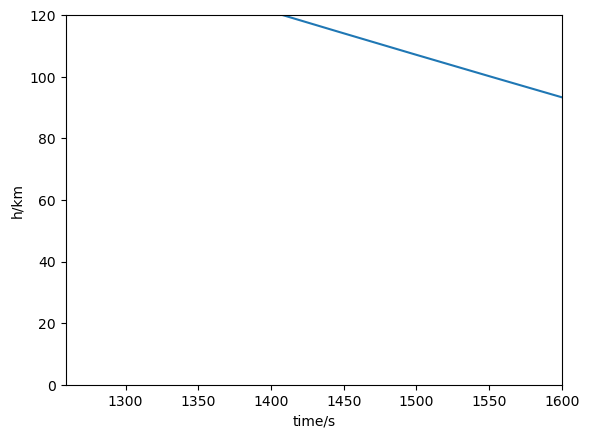

In [100]:
print(f"Final apogee of {orb_fin.r_a-Earth.R}")
print(f"Final perigee of {orb_fin.r_p-Earth.R}")
plt.ylabel("h/km")
# plt.xlabel("distance downrange, km")
plt.xlabel("time/s")
plt.xlim(1259,1600)
plt.ylim(top = 120)
plt.plot(tofs, pos_spherical.distance - Earth.R)
reentry_time=reentry_time-entry_interface

Entry interface at 1668.4208747360165 seconds
Lithobrake event seen at 3019.717466688148 seconds


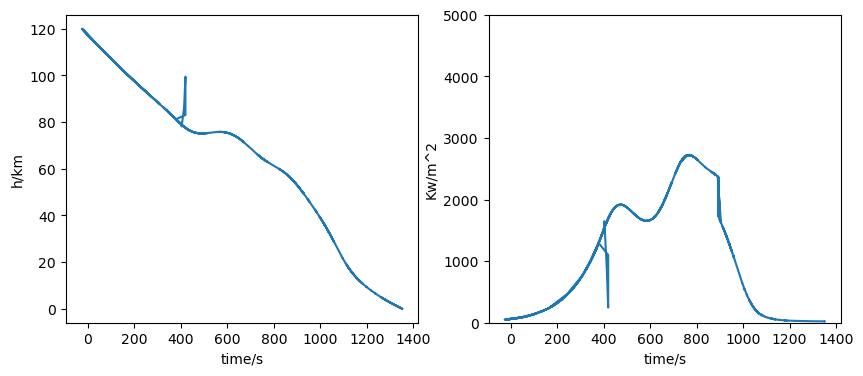

In [101]:

impact_time = 0
if entry_interface >0:
    print(f"Entry interface at {entry_interface} seconds")
if lithobrake_event.last_t.to(u.s)< prop_time:
    impact_time = lithobrake_event.last_t.to(u.s)
    print(f"Lithobrake event seen at {lithobrake_event.last_t.to(u.s).value} seconds")


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))


ax1.set_ylabel("h/km")
# plt.xlabel("distance downrange, km")
ax1.set_xlabel("time/s")
#plt.xlim(12500,14000)
#plt.ylim(top = 100)
#print(reentry_alts)
plt.ylim(bottom=0, top=20000)
ax1.plot(np.array(reentry_time),np.array(reentry_alts))
#drag 0.47813373175961593 hours
#none 0.4863379477979069 hours
#print(np.array(reentry_vel)[15])
# plt.ylim(15)
ax2.set_ylim(top=5000)
ax2.set_xlabel("time/s")
ax2.set_ylabel("Kw/m^2")
ax2.plot(np.array(reentry_time),np.array(heat_fluxs))
#17GW!!!!!

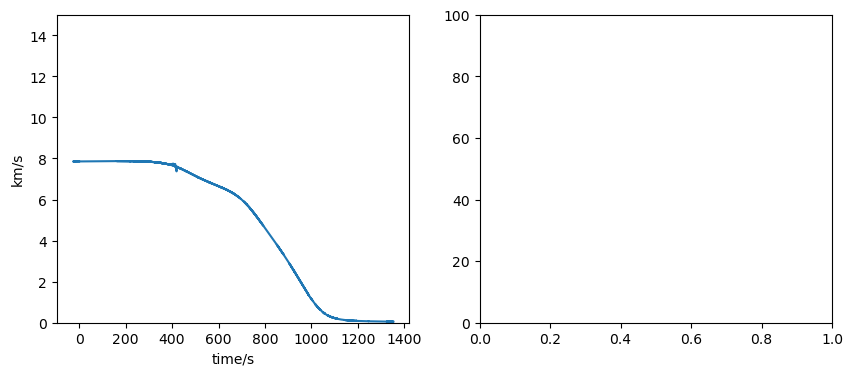

In [102]:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))


ax1.set_ylabel("km/s")
# plt.xlabel("distance downrange, km")
ax1.set_xlabel("time/s")
#plt.xlim(12500,14000)
plt.ylim(top = 100)
#print(reentry_alts)
ax1.set_ylim(top=15)
ax1.plot(np.array(reentry_time),np.array(reentry_vel))
#drag 0.47813373175961593 hours
#none 0.4863379477979069 hours
#print(np.array(reentry_vel)[15])
#lt.ylim(15)
# ax2.set_xlabel("time/s")
# ax2.set_ylabel("Kw/m^2")
# ax2.plot(np.array(reentry_time),np.array(heat_fluxs))